# Week 1 Iceclassic Content and Plots

### Tasks:

1.  ~~Use dictionaries to store dataset metadata and information about break-up years~~ 
2. ~~Datasets are stored as a dictionary of dictionaries:~~
3. ~~Time series plots~~
    - ~~all years on top of each other with break-updecimal dayas a red dot with black border~~ 
    - •~~Optional year labels (small!)~~…**maybe even passing a string to easily customize formatting of label**
    - ~~Keyword argument allows highlighting and/or plotting a subset (specified with  a list)~~
        - ~~subset of columns(variables in df), `keyword=columns_to_plot=[]`~~
        - ~~subset of years, `keyword=multiyear=[]`~~ 
    - (Partially completed) ~~Keyword argument allows “normalizing” the plots such that the break-up date for each year is in the center and the plot shows a number of weeks on each side~~
        - Using `xaxis='Days until break up` normalizes such the break up happens at x=0, with `xlim=[]` we can choose how many days before or after to plot
        
4. Scatter Plots
    - ~~We want to generalize this for any observed or derived variable~~
        - ~~Derived variable from the timeseries data can be easily created as shown on section 1(temperature,ice thickness).~~  **the number of derived variable can be easily expanded**
        - Instead of annotation with year, maybe add colorbar/or arrow fraom annotation to point to avoid overlap ? (cop


### Datesets

Two dataset are needed

1. list of break_up_dates (`'../../data/List_break_up_dates.csv')`
2. csv file with compiled timeseries (`../../data/Time_series_DATA.txt"`)

> I'm still looking for more dataset related to gage_height as there are only a few years of data recorder by the USGS Nenana Station.

## Importing files and selecting the datasets that we will use


In [1]:
import pandas as pd
from datetime import time ,datetime,timedelta
import pprint # for printing dictionaries
import matplotlib.pyplot as plt
from funciones import * # this is up-to-date content of iceclassic package that is (temporarily) stored in this repo, will release the final version sometime this wknd

#Break up dates list
dates = pd.read_csv('../../data/List_break_up_dates.csv',names=['date_time'],header=None)
dates['date_time']=pd.to_datetime(dates['date_time'])


# External Variables
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
selected_cols=['Regional: Air temperature [C]','Nenana: Rainfall [mm]','Nenana: Snowfall [mm]','Nenana: Mean Discharge [m3/s]','IceThickness [cm]']
Data=Data[selected_cols]


## 1. Use dictionaries to store dataset metadata and information about break-up years

We use `groupby-apply-tranform` in variables from `Data`(df with all the data) to collapse a year of data to a single value per year, then re-index to align.

In [2]:
# creating a dictionary for every break up date, then creating a dictionary with the dictionaries
dates = pd.read_csv('../../data/List_break_up_dates.csv',names=['date_time'],header=None)
dates['date_time']=pd.to_datetime(dates['date_time'])




#=========================================================================================#
#  keys related to break_up dates 
#=========================================================================================#
dates['year']=dates['date_time'].dt.year
dates['month']=dates['date_time'].dt.strftime('%B')
dates['day']=dates['date_time'].dt.day
dates['day_of_year']=dates['date_time'].dt.dayofyear

dates.index=dates['year']

dates['days_since_01_apr']=dates['date_time'].apply(lambda dt : (dt-pd.Timestamp(year=dt.year,month=4,day=1)).days)
dates['time']=dates['date_time'].dt.time
dates['hour']=dates['date_time'].dt.hour
dates['minute']=dates['date_time'].dt.minute

dates['decimal_time']=round(dates['date_time'].dt.time.apply(lambda t: decimal_time(t,direction='to_decimal')),4)
dates['decimal_day_of_year']=round(dates['time'].apply(lambda t: decimal_day(t,direction='to_decimal'))+dates['day_of_year'],8)
# decimal day
# decimal year, etc


#=========================================================================================#
#  keys related to ice_thickness 
#=========================================================================================#
Ice=Data['IceThickness [cm]'].dropna()  # to make the following lines cleaner
dates['max_ice_thickness'] =Ice.groupby(Ice.index.year).max().reindex(dates.index,method=None)
dates['day_of_max_ice_thickness']=Ice.groupby(Ice.index.year).idxmax().reindex(dates.index,method=None)
dates['last_ice_measurement']=Ice.groupby(Ice.index.year).last().reindex(dates.index,method=None)
dates['day_of_last_ice_measurement']=Ice.groupby(Ice.index.year).apply(lambda x: x.index[-1]).reindex(dates.index,method=None)

dates['n_days_last_measured_ice_&_break_up']=dates.apply( lambda row: (row['day_of_last_ice_measurement']-row['date_time']).days if pd.notna(row['day_of_last_ice_measurement']) and pd.notna(row['date_time']) else None,axis=1)



dates['final_melting_gradient[cm/day]']=Ice.groupby(Ice.index.year).apply(lambda x: (x.iloc[-2]-x.iloc[-1])/(x.index[-2]-x.index[-1]).days).round(3).reindex(dates.index,method=None)
# if we define that break up happens wiht ice thickness equal to zero, the final melting gradient would be computed diffentle, but not always the break-up happens when the thickness is zero.
dates['melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]']=round(dates['last_ice_measurement']/dates['n_days_last_measured_ice_&_break_up'],3)
#=========================================================================================#
#  keys related to temperature
#=========================================================================================#
Temp=Data['Regional: Air temperature [C]'].dropna()
dates['days_over_minus_2'] = Temp.groupby(Temp.index.year).apply(lambda x: (x > -2).sum()).astype(int).reindex(dates.index,method=None) # assumes that the number of day over 1 since the start of ice formation to jan 01 is zero 
dates['cumsum_over_2_temp']= Temp.groupby(Temp.index.year).apply(lambda x: x.clip(lower=0).where(x > 2).sum()).round(3).reindex(dates.index,method=None)
dates['avg_temp']=Temp.groupby(Temp.index.year).mean().round(2)
# min tem, max temp, min tem in jan, etc

#=========================================================================================#
#  converting df to dict of dict and list of dict 
#=========================================================================================#

# print('Printing Dataframe\n=====================')
# print(dates)

dict_of_dict=dates.to_dict(orient='index')
#print('Printing dict of dict\n=====================')
#pprint.pprint(dict_of_dict,sort_dicts=False) # to avoid PrettyPrint printing the keys alphabetically


# list_of_dict=dates.to_dict(orient='records')
# print('Printing list of dict\n=====================')
# pprint.pprint(list_of_dict,sort_dict-False)


#=========================================================================================#
#  accessing element of dict_of_dict
#=========================================================================================#
# because we assigned the year to each dict we can simply pass the year to get the data related to the break up of that year
pprint.pprint(dict_of_dict[2015],sort_dicts=False)  

{'date_time': Timestamp('2015-04-24 14:25:00'),
 'year': 2015,
 'month': 'April',
 'day': 24,
 'day_of_year': 114,
 'days_since_01_apr': 23,
 'time': datetime.time(14, 25),
 'hour': 14,
 'minute': 25,
 'decimal_time': 14.4167,
 'decimal_day_of_year': 114.60069444,
 'max_ice_thickness': 97.79,
 'day_of_max_ice_thickness': Timestamp('2015-03-05 00:00:00'),
 'last_ice_measurement': 85.09,
 'day_of_last_ice_measurement': Timestamp('2015-04-06 00:00:00'),
 'n_days_last_measured_ice_&_break_up': -19.0,
 'final_melting_gradient[cm/day]': -1.27,
 'melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]': -4.478,
 'days_over_minus_2': 219.0,
 'cumsum_over_2_temp': 1754.84,
 'avg_temp': -0.77}


## 2. Datasets are stored as a dictionary of dictionaries:


In [3]:
variable_summary={}

n_total=len(Data.index.year.unique())
print(n_total)

for column in Data.columns:
    first_obs=Data.index.year.min()
    last_obs=Data.index.year.max()
    avg_n_obs_yearly=Data[column].groupby(Data.index.year).count().mean().round(2)
    historic_max=Data[column].max().round(2)
    yearly_avg=Data[column].mean().round(2)
    n_years=Data[Data[column].notna()].index.year.unique()
    n_year_percent=round((len(n_years)/n_total*100),2)
    variable_summary[column]={
        'year_start':first_obs,
        'year_end':last_obs,
        'avg_n_yearly': avg_n_obs_yearly,
        'historic_max': historic_max,
        'yearly_avg': yearly_avg,
        'years_present (%)':n_year_percent,
        'years_present':n_years}
    


pprint.pprint(variable_summary['Regional: Air temperature [C]'],sort_dicts=False)


107
{'year_start': 1917,
 'year_end': 2023,
 'avg_n_yearly': 360.4,
 'historic_max': 23.23,
 'yearly_avg': -2.61,
 'years_present (%)': 99.07,
 'years_present': Index([1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       ...
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', length=106)}


>To get more info we can always use the function `explore_contents` from the iceclassic package, more ways to visualize the contents can be seen in the book section `Loading_&_Exploring_Data.ipynb`, like the interactive plots and the timeseries plots/distribution of each variable/column


## 3. Time Series Plots

#### 3.1/3.2/3.3 Plotting, labels and highlighting years
We will use a slightly updated version from the function `plot_contents` from the iceclassic package, the updated version can be found in `/funciones.py`, and has not been 
committed/uploaded to its individual repo nor released to PyPi
\


More examples on how to use the function can be found in the book in the section `Seasonality(groupby-transform-apply).ipynb`

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39081 entries, 1917-01-01 to 2023-12-31
Data columns (total 24 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29516 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22525 non-null  float64
 8   Nenana: Air temperature [C]                        31146 non-null  fl

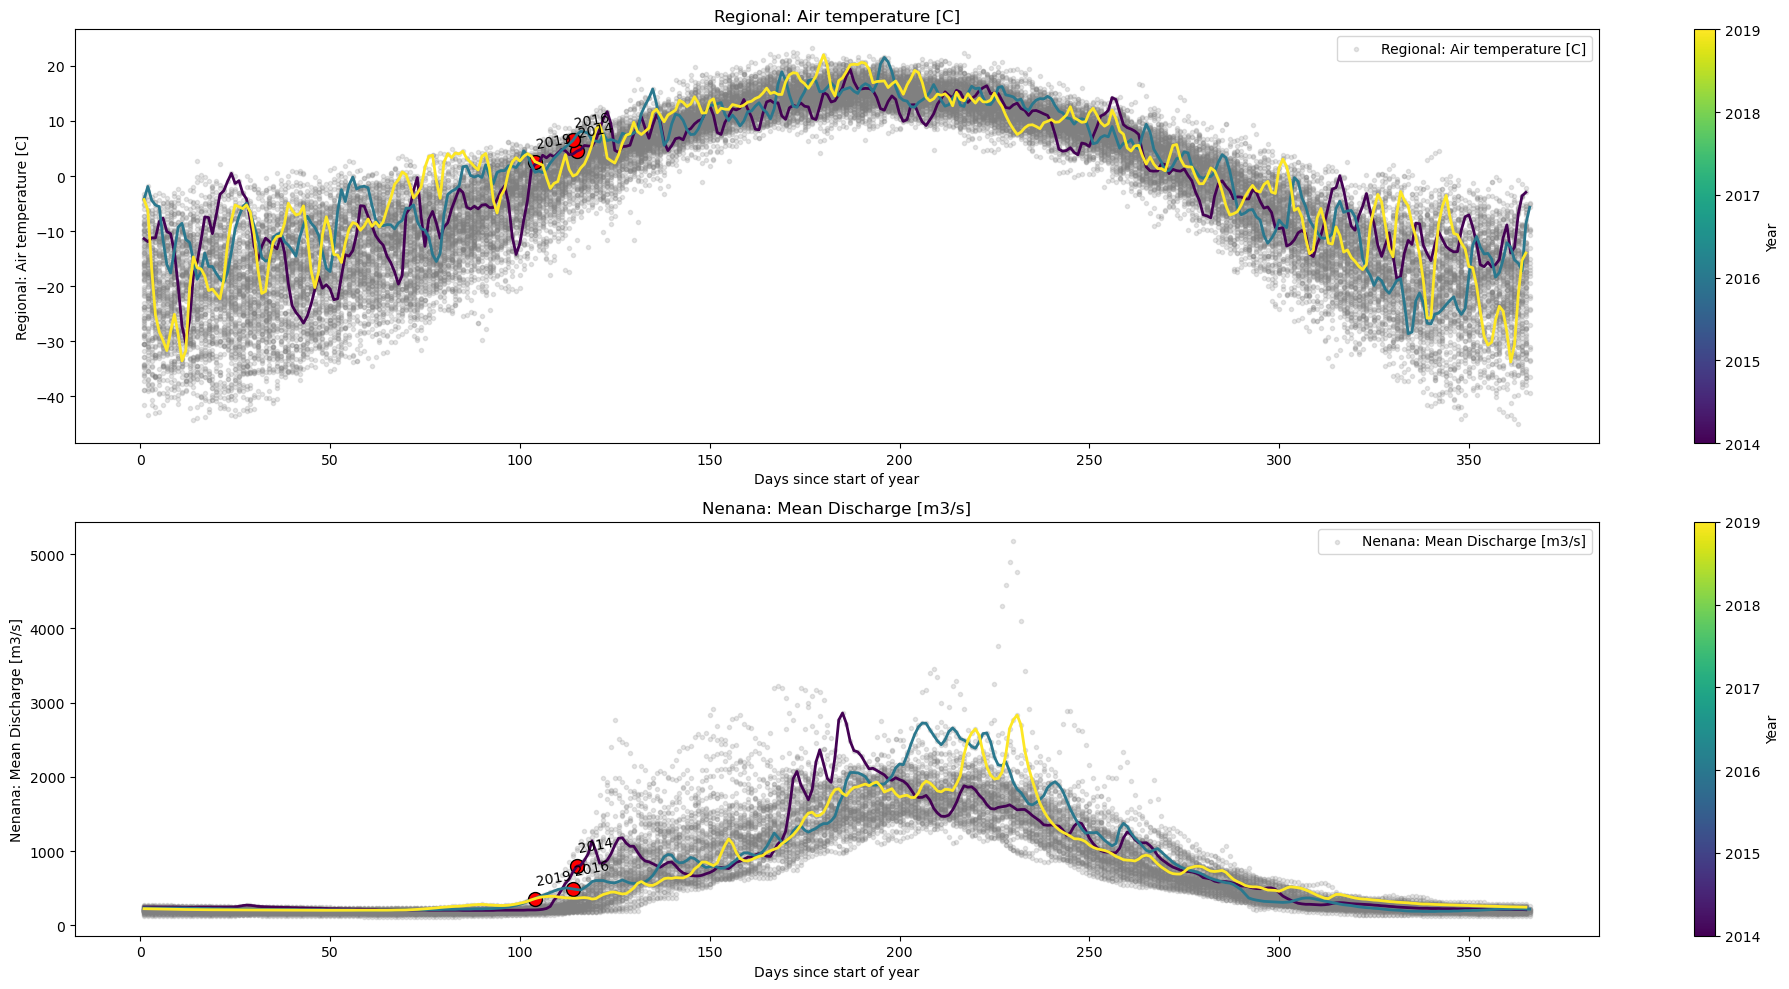

In [4]:


# we reload df cuz we need some column that we dropped at the beginning
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 
Data.info()

plot_contents(Data,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],     # what columns to plot, default all
              col_cmap=['grey'],                                     # list of colors for each column, default is sequential cmap, but list of colors can be passed as well
              scatter_alpha=0.2,                                     # we can 'mute' the scatter points if we choose lapha=0, then the col_map is irrelevant, cuz the scatter markers are no being plotted
              plot_mean_std=False,                                   # we 'mute' the baseline across all years, similar here, if it were 'True' the color would have been grey' 
              multiyear=[2014,2016,2019],                            # we select which years to highlight
              years_line_width=2,                                    # change the iwth of line if necessary
              plot_break_up_dates=True)                              # plotting break_up_dates makers with annotations, default =False 

 
> fix,  move scatter point to the front of plot, add arrows between the label and the point.

the argument  `xlim` can be passe to restrict the xaxis

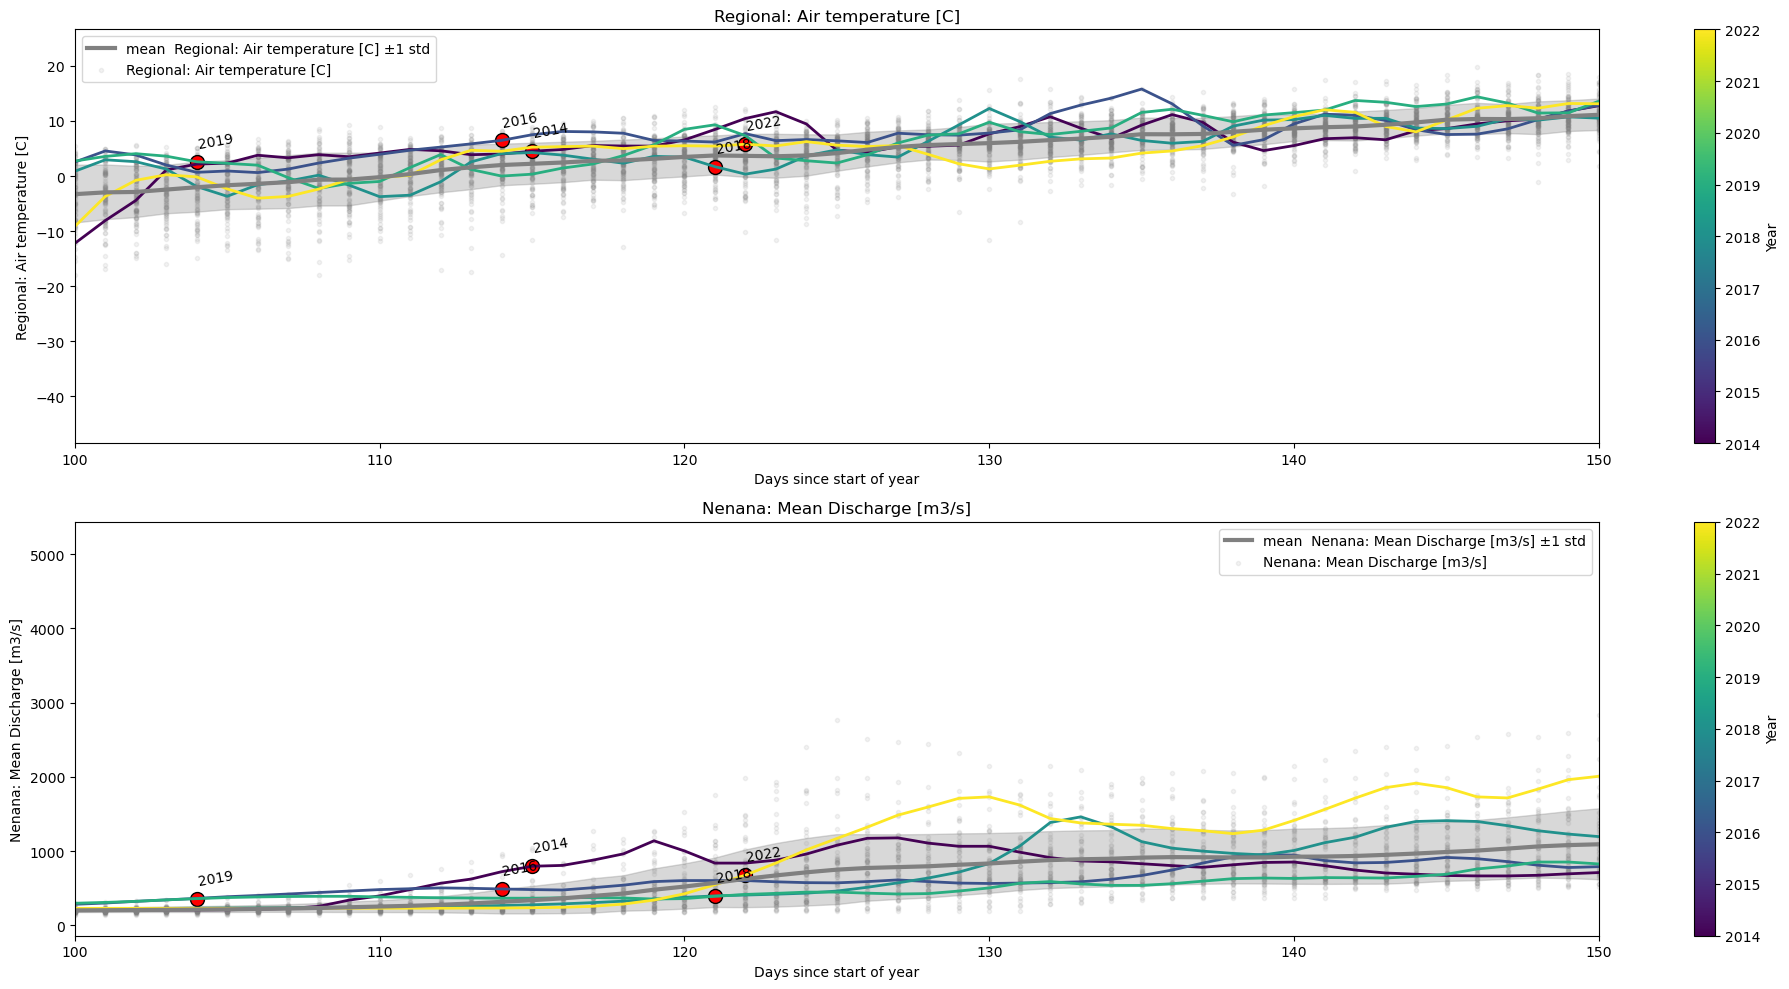

In [5]:
from funciones import*

# we reload df cuz we need days to breal up and days of year colums
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data = Data[(Data.index.year >= 1917) & (Data.index.year < 2024)] 

plot_contents(Data,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],    # what column to plot, default all
              col_cmap=['grey'],                                    # list of colors for each column, default is sequential cmap
              scatter_alpha=0.1,                                    # we 'mute' the scatter points
              plot_mean_std=True,                                   # now we plot the baseline across all years
              multiyear=[2014,2016,2018,2019,2022],                 # we select which years to choose
              plot_break_up_dates=True,                             # plotting break_up_dates scatter default =False 
              years_line_width=2,                                   # line with a litlte bit narrower than dafault=4
              xlim=[100,150])                                       # xlimits

### 3.4 Normalizing x-axis

The easiest way to normalize xaxis is by choosing xaxis='Days until break up' ( which is a column in Data).

With this axis, there is no need to put annotations with the year, because we know that data is normalized such that the breakup happens at xaxis=0.


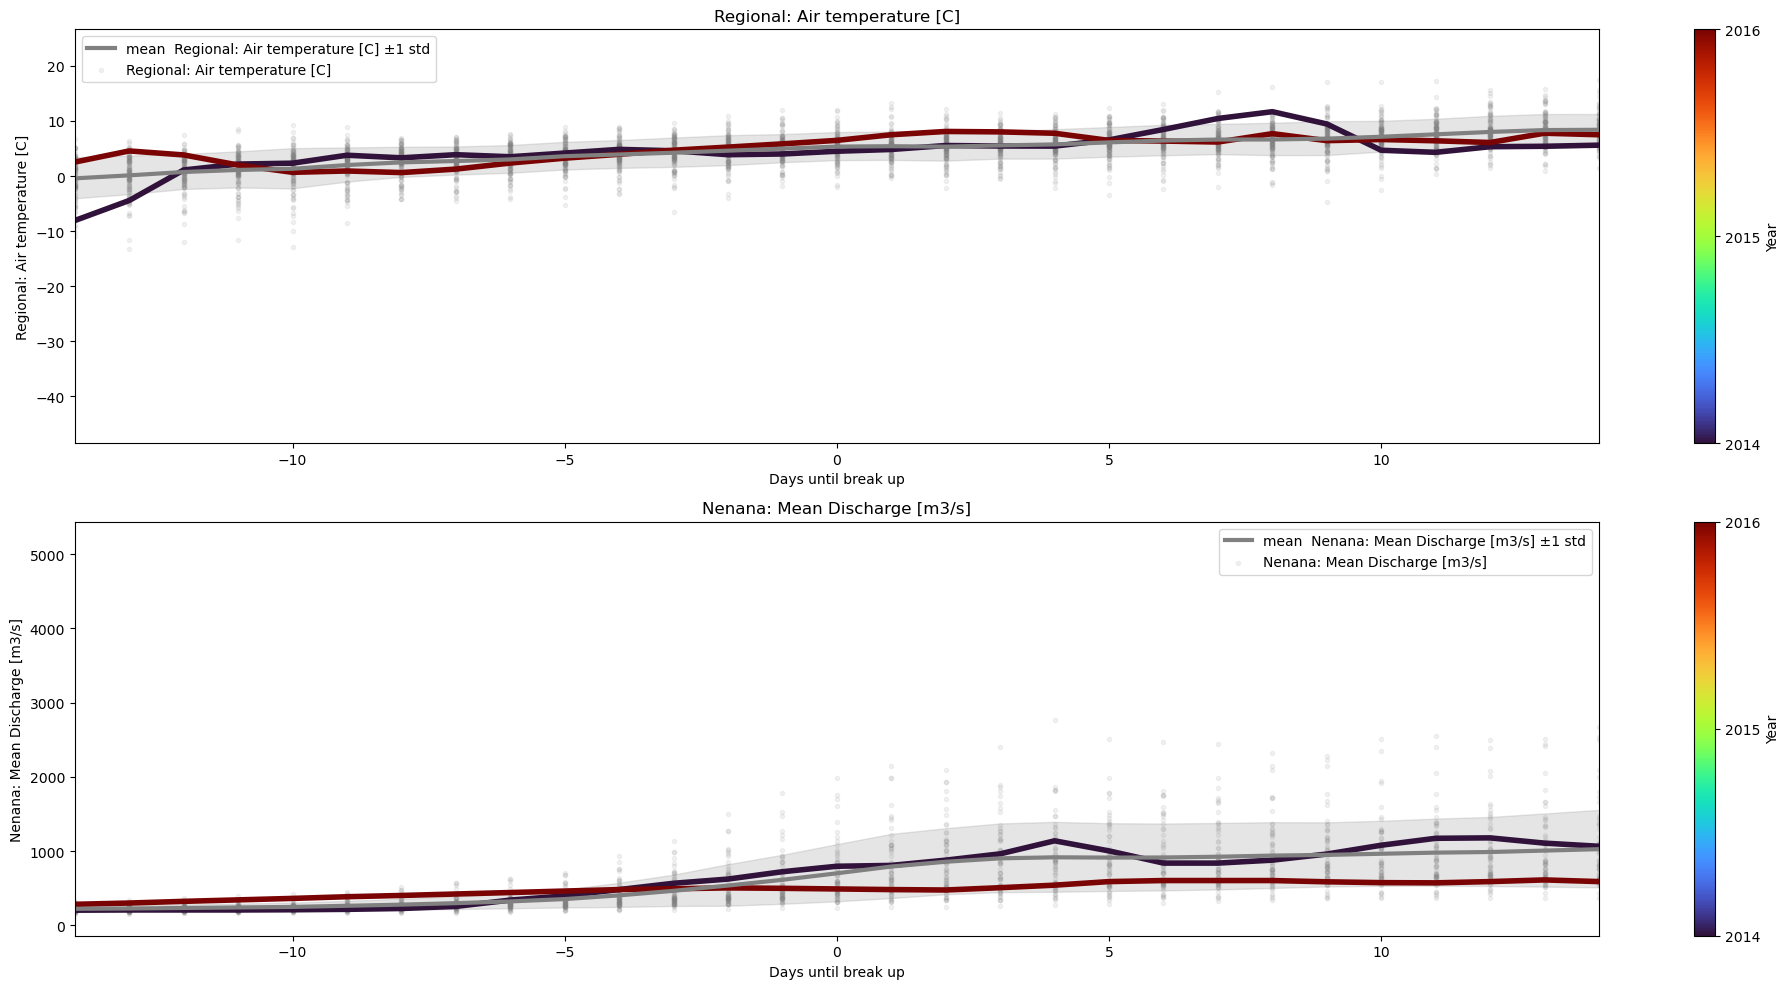

In [6]:
plot_contents(Data,
              xaxis='Days until break up',
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],    # what column to plot, default all
              col_cmap=['grey'],                                    # list of colors for each column, default is sequential cmap
              std_alpha=0.2,                                        # alpha for the fill
              plot_mean_std=True,                                   # if we put true the baseline plus scatter are plotted
              multiyear=[2014,2016],                                # we select which years to choose
              plot_break_up_dates=True,                             # plotting break_up_dates scatter default
              xlim=[-14,14],
              years_cmap='turbo')                                   # we can pass other cmaps for the colorbar

## 4. Scatter Plots

 Because the df/dict is already aligned, we can easily access and plot stuff.

We can use any of the column of `dates` as either x or y vectors.

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 1917 to 2023
Data columns (total 21 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   date_time                                                      107 non-null    datetime64[ns]
 1   year                                                           107 non-null    int32         
 2   month                                                          107 non-null    object        
 3   day                                                            107 non-null    int32         
 4   day_of_year                                                    107 non-null    int32         
 5   days_since_01_apr                                              107 non-null    int64         
 6   time                                                           107 non-null    object        
 7   

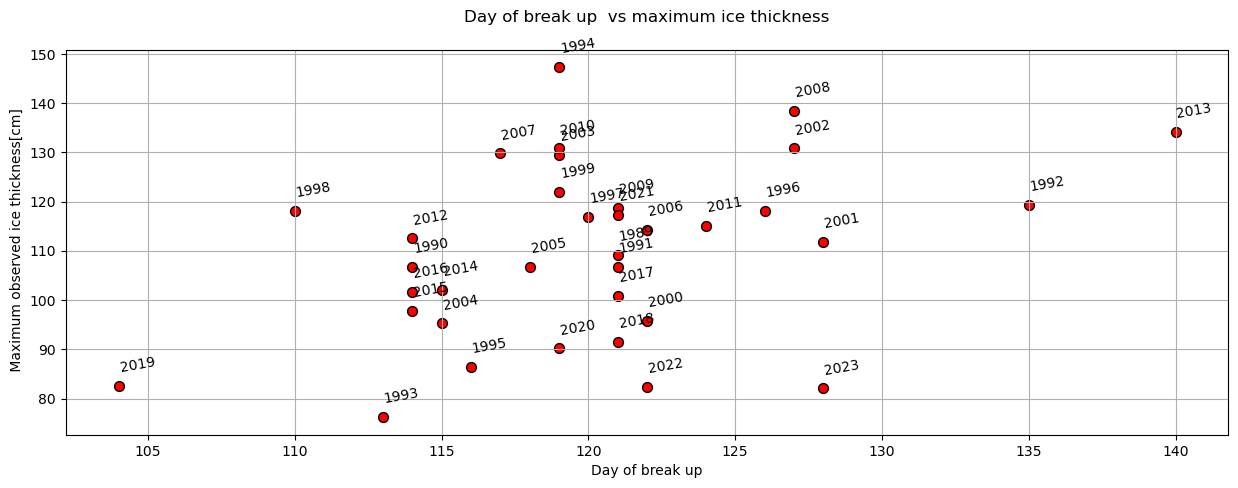

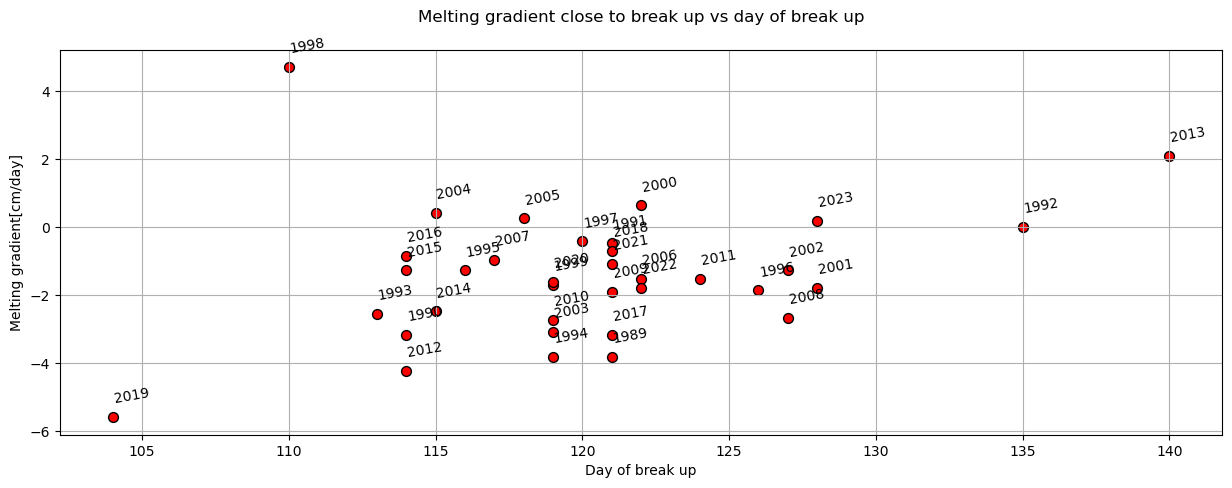

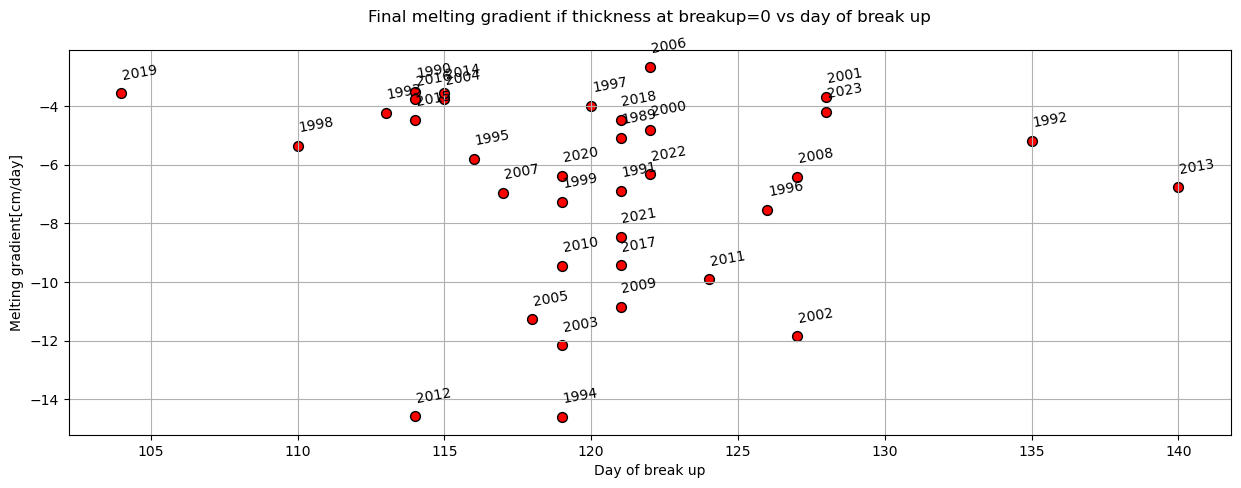

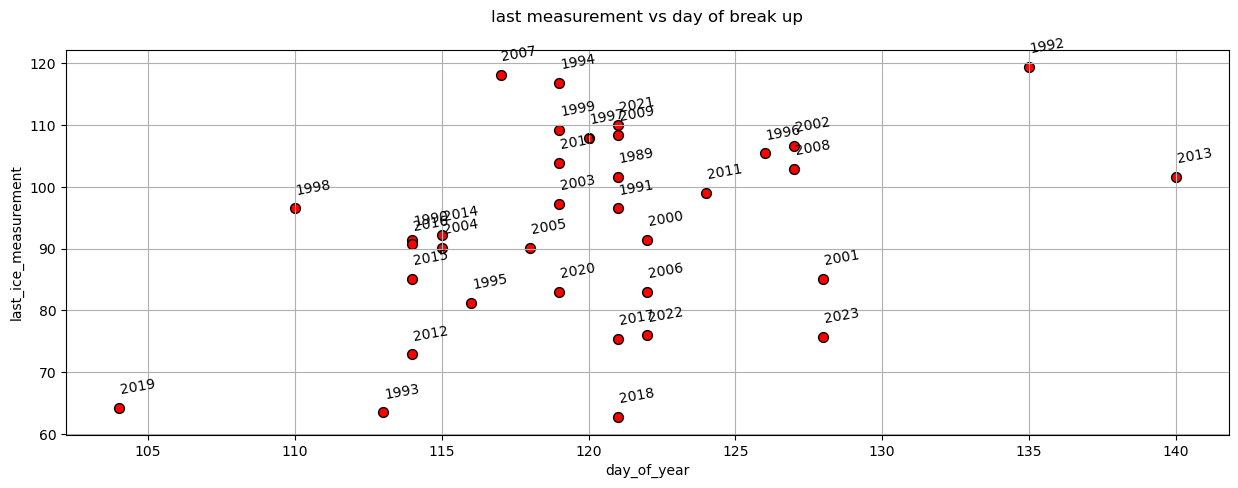

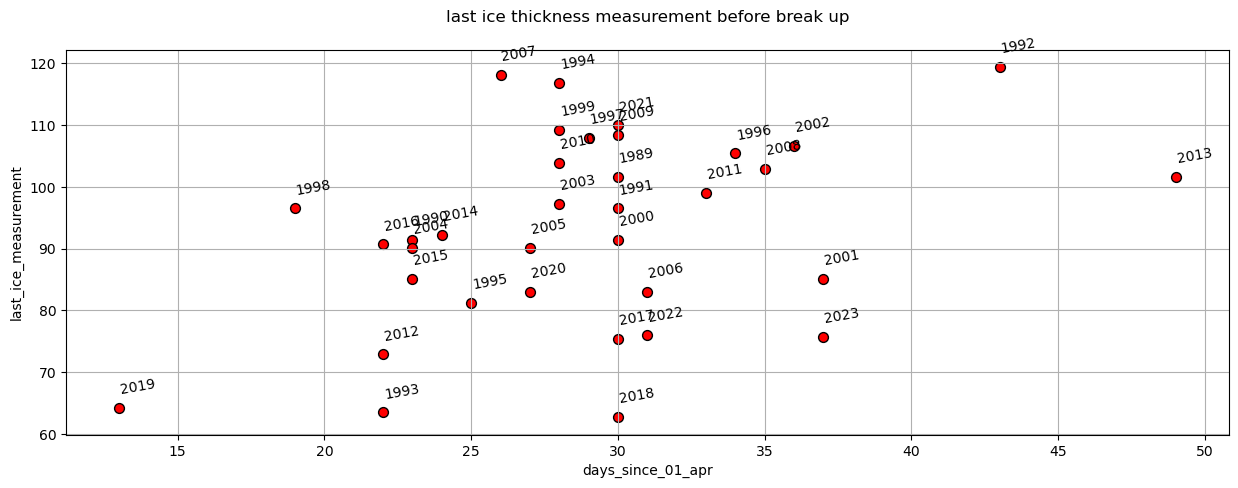

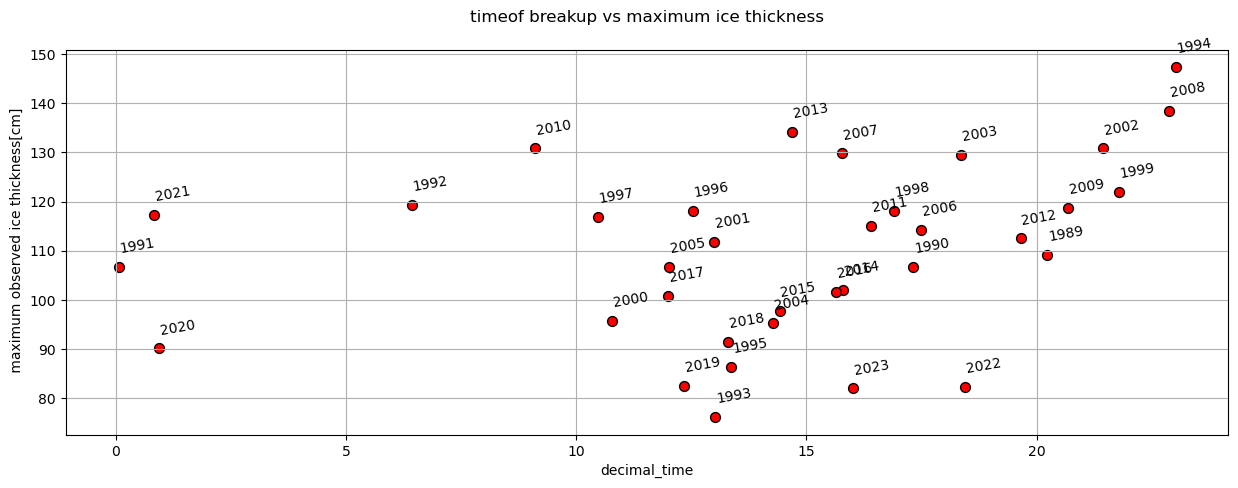

In [7]:
dates.info()

plot_scatter(dates,'day_of_year','max_ice_thickness',x_label='Day of break up',y_label=' Maximum observed ice thickness[cm]',title='Day of break up  vs maximum ice thickness')
plot_scatter(dates,'day_of_year','final_melting_gradient[cm/day]',x_label='Day of break up',y_label='Melting gradient[cm/day]',title='Melting gradient close to break up vs day of break up')
plot_scatter(dates,'day_of_year','melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]',x_label='Day of break up',y_label='Melting gradient[cm/day]',title='Final melting gradient if thickness at breakup=0 vs day of break up')
plot_scatter(dates,'day_of_year','last_ice_measurement',title='Last measurement vs day of break up')
plot_scatter(dates,'days_since_01_apr','last_ice_measurement',title='Last ice thickness measurement before break up')
plot_scatter(dates,'decimal_time','max_ice_thickness',x_label='Decimal time',y_label='Maximum observed ice thickness[cm]',title='Time of breakup vs maximum ice thickness')



# Other plots
Examples of other plots that we can make withe de function that we have

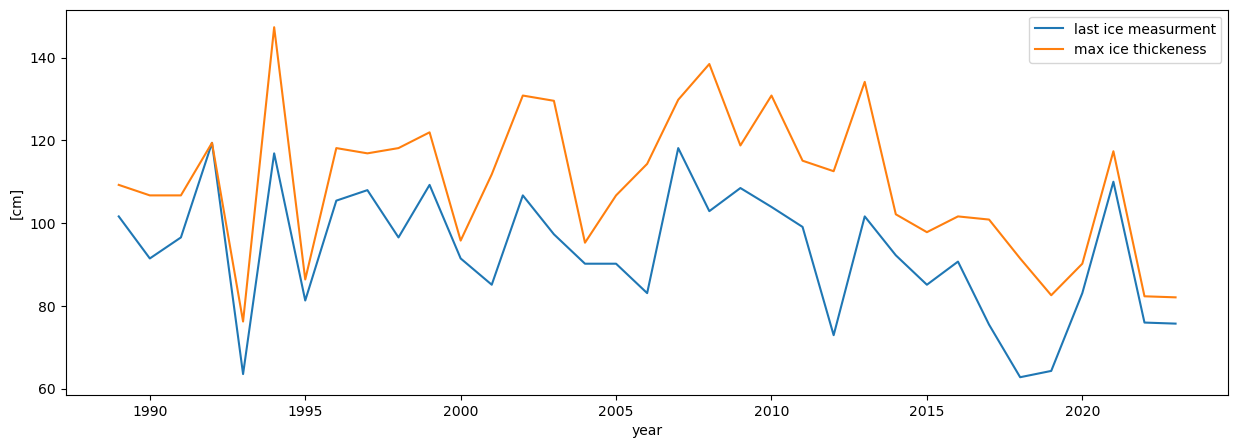

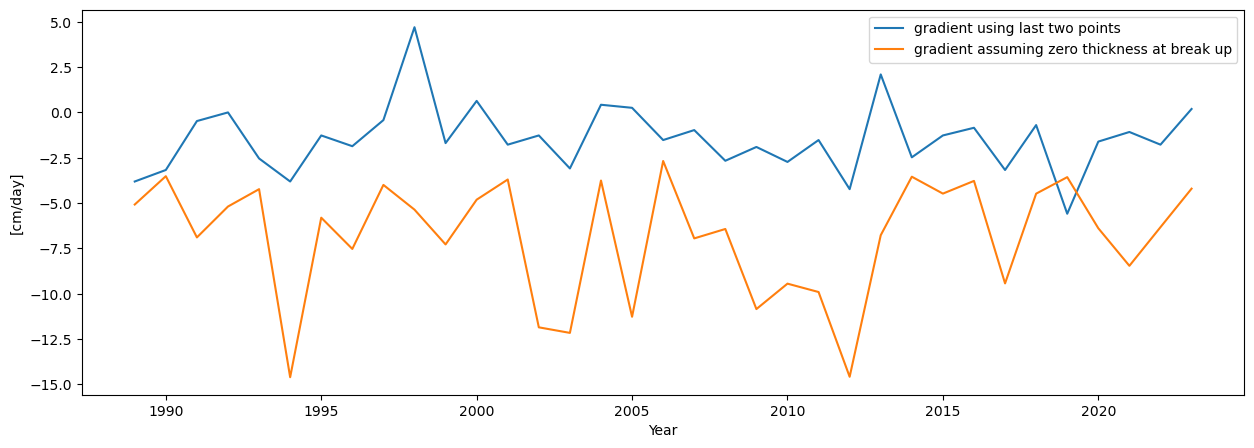

In [8]:
plt.figure(figsize=(15,5))
plt.plot(dates['last_ice_measurement'],label='last ice measurment')
plt.plot(dates['max_ice_thickness'],label='max ice thickeness')
plt.ylabel('[cm]')
plt.xlabel('year')
plt.legend()
plt.show()


plt.figure(figsize=(15,5))
plt.plot(dates['final_melting_gradient[cm/day]'],label='gradient using last two points')
plt.plot(dates['melting_gradient_if_breakup_happens_at_zero-thickness[cm/day]'],label='gradient assuming zero thickness at break up')
plt.ylabel('[cm/day]')
plt.xlabel('Year')
plt.legend()

## Other Scater/TimeSeries plots

For scatter plot that use more than one value per year per variable, revert to using `plot_contents`, as we pass any column to use as xaxis.

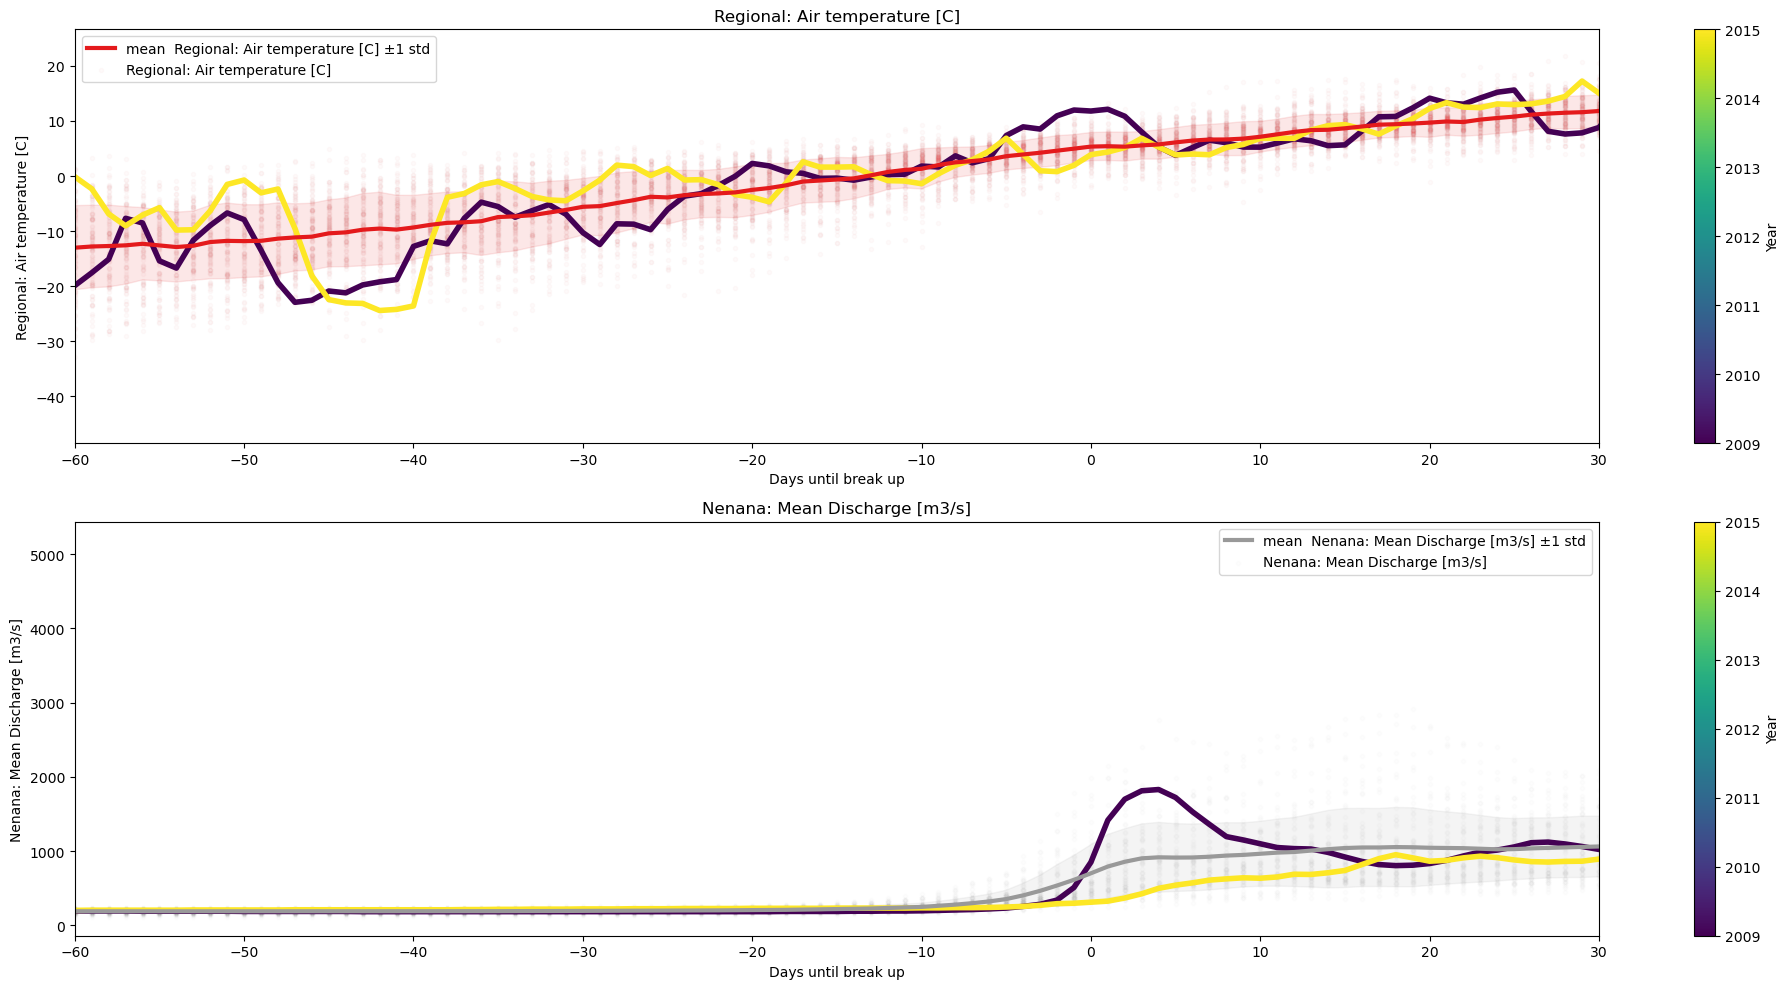

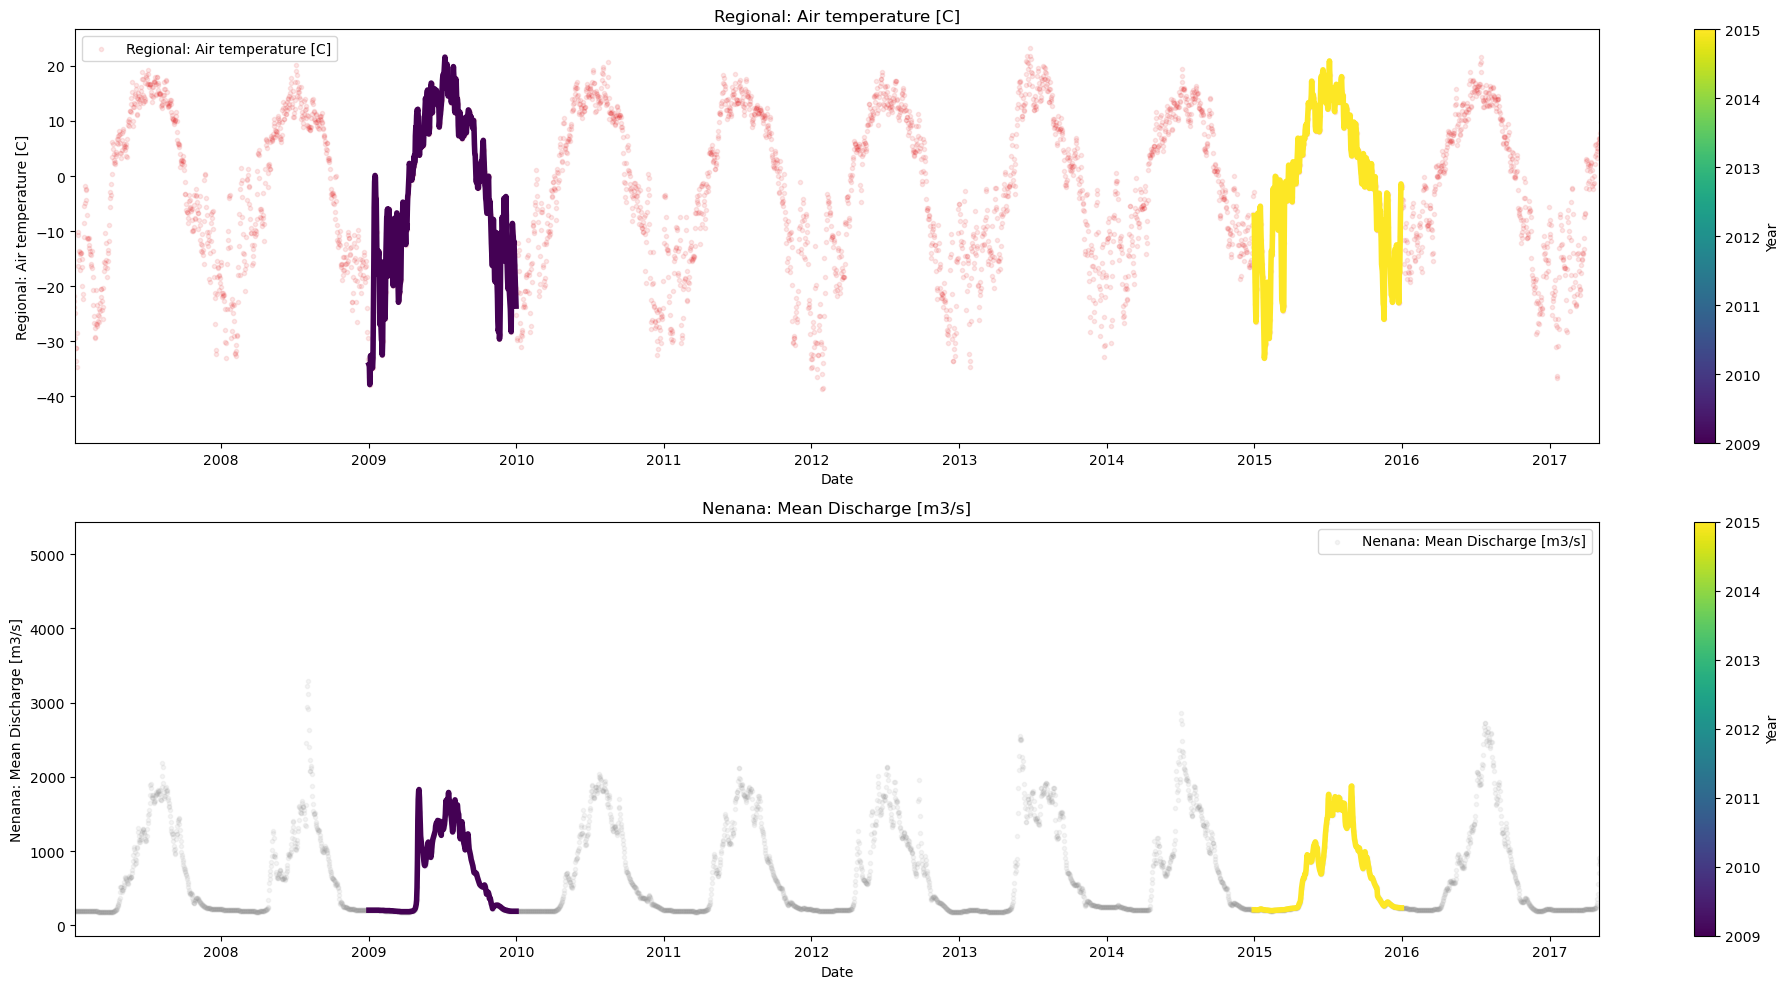

In [9]:
selected_years = [2009,2015]
plot_contents(Data,
              multiyear=selected_years,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],
              xaxis='Days until break up',
              xlim=[-60,30],
              plot_mean_std='true',
              scatter_alpha=.02,
              std_alpha=.1) 

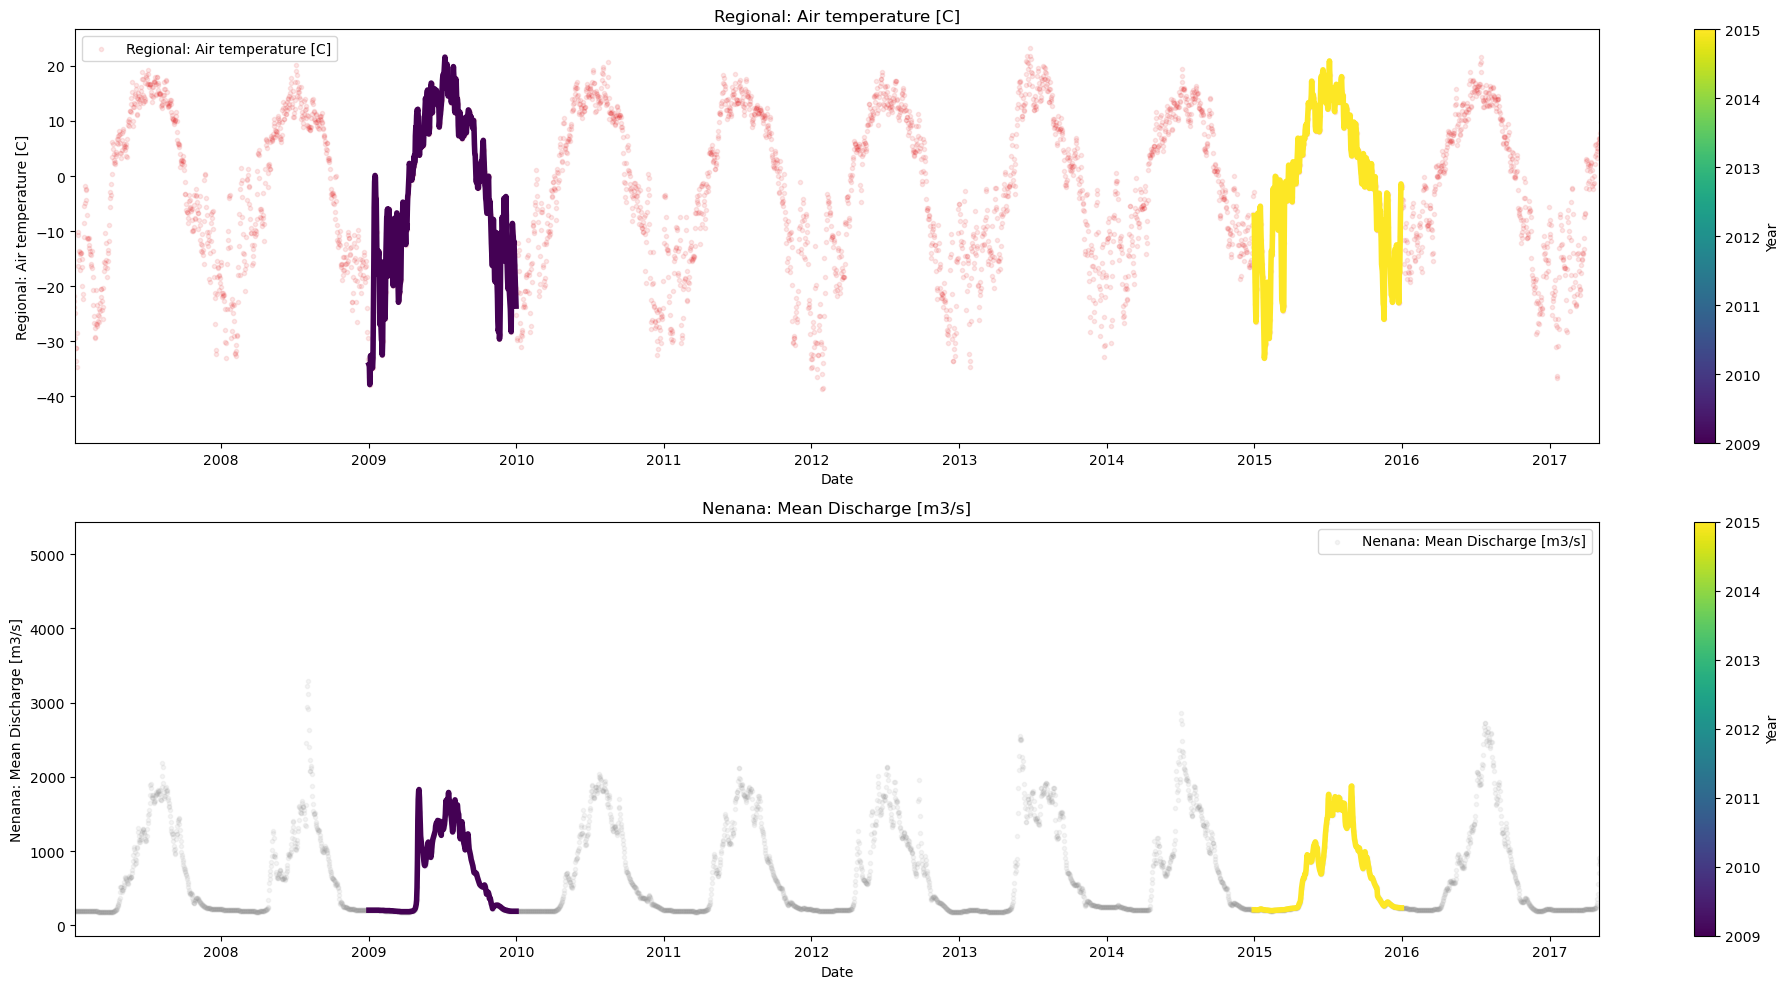

In [12]:
plot_contents(Data,
              multiyear=selected_years,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],
              xaxis='index',
              xlim=['2007/01/04','2017/05/03']) 

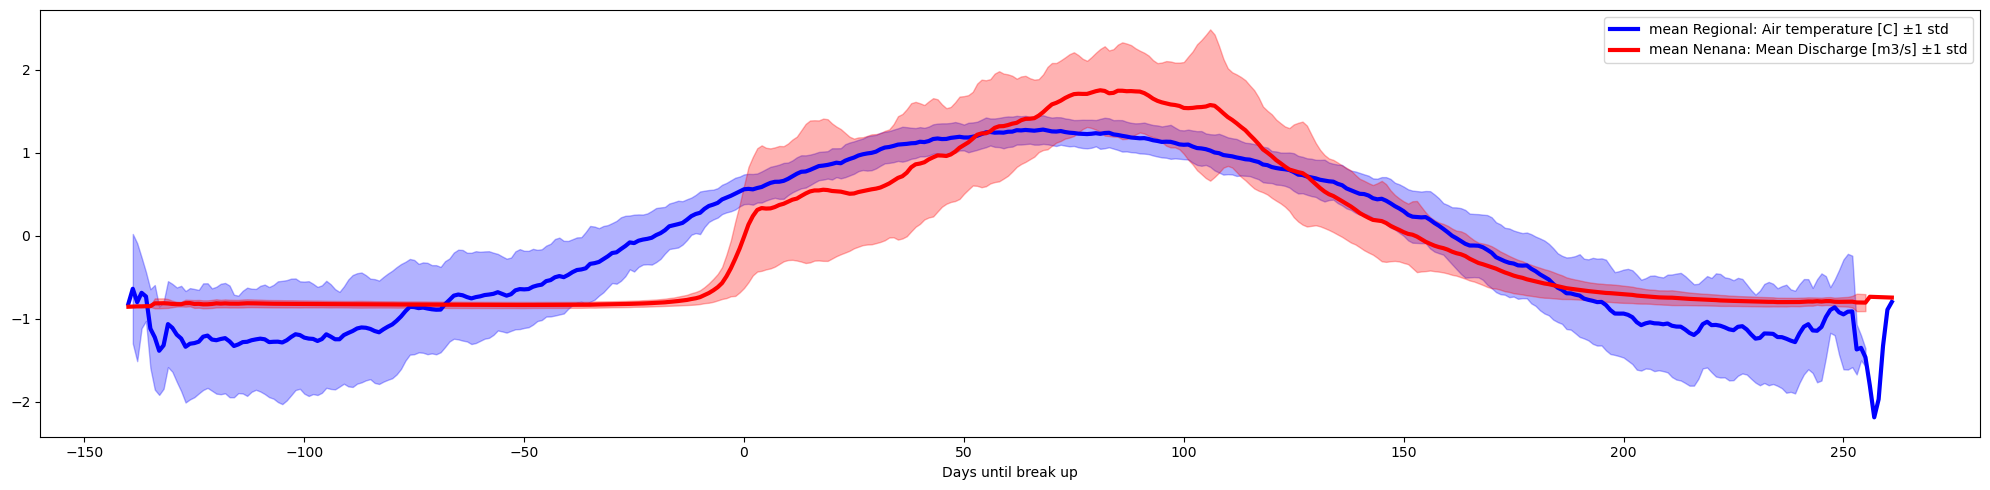

In [19]:
plot_contents(Data,
              columns_to_plot=['Regional: Air temperature [C]','Nenana: Mean Discharge [m3/s]'],
              plot_together=True,
              plot_mean_std='only',
              k=1,normalize='z-score',
              xaxis='Days until break up',col_cmap=['blue','red'])